In [1]:
%load_ext autoreload
%autoreload 2
%aimport -jax
%aimport -jaxlib

In [2]:
env_name = "quadrotor"
from stanza.reporting import Repo
from pathlib import Path

repo = Repo("wandb://dpfrommer-projects")
data = repo.find(data_for=env_name).latest
trajs = data.get("trajectories")

import stanza.envs as envs
env = envs.create(env_name)

In [16]:
import jax
import jax.numpy as jnp

traj0 = trajs[19].data
from stanza.util.ipython import display_video
video = jax.vmap(
    lambda x, y: env.render(x, state_trajectory=y),
    in_axes=(0, None)
)(traj0.state, traj0.state)
display_video(video)

In [4]:
from stanza.util import extract_shifted

states_early, states_late = extract_shifted(traj0.observation)
actions = jax.tree_map(lambda x: x[:-1], traj0.action)
reward = jnp.sum(jax.vmap(env.reward)(states_early, actions, states_late))
print(f"Reward: {reward}")

Reward: 44.19020462036133


In [5]:
from stanza.data import PyTreeData
import jax.flatten_util
from jax.random import PRNGKey

data = PyTreeData.from_data(trajs.flatten()).shuffle(PRNGKey(42)).data
data = jax.tree_map(lambda x: x[:300], data)
obs, actions, Ks = data.observation, data.action, data.info.K
flatten = jax.vmap(lambda x: jax.flatten_util.ravel_pytree(x)[0])
obs, actions = flatten(obs), flatten(actions)

KeyboardInterrupt: 

In [ ]:
if env_name == "pendulum":
    import plotly.graph_objects as go
    fig = go.Figure()
    x, y, z= obs[:, 0], obs[:, 1], actions[:, 0]
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode="markers"))

    x, y = jnp.linspace(-3, 8, 10), jnp.linspace(-3, 8, 10)
    xs, ys = jnp.meshgrid(x, y)
    xs, ys = xs.reshape(-1), ys.reshape(-1)

    i = 5
    K, x0, z0 = Ks[i], obs[i], actions[i,0]
    z = jax.vmap(lambda x, y: jnp.squeeze(K @ (jnp.stack((x,y)) - x0) + z0))(xs, ys)
    z = z.reshape((x.shape[0], y.shape[0]))
    fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.5))

    fig.update_layout(scene=dict(xaxis_title="angle", yaxis_title="vel", zaxis_title="action"))
    fig.show()


In [ ]:
# exp = db.open("diffusion_policy/silver-star-356")
# val_exp_data = exp.get("test_expert")
# val_policy_data = exp.get("test_policy")

# for i in range(1):
#     exp_traj = jax.tree_map(lambda x: x[i], val_exp_data)
#     pol_traj = jax.tree_map(lambda x: x[i], val_policy_data)
#     video = jax.vmap(env.render)(pol_traj.states)
# display_video(video)

In [ ]:
import wandb
import pandas as pd
from IPython.display import display
api = wandb.Api()
sweep = api.sweep("dpfrommer-projects/stanza/b2g7k47q")

data = []
for r in sweep.runs:
    if "test_reward" not in r.summary:
        continue
    d = {
        "num_traj": r.config["num_trajectories"],
        "lambda_param": r.config["lambda_param"],
        "lambda_val": r.config["lambda_val"],
        "entrypoint": "diffusion" if "diffusion_bc" in r.config["entrypoint"] else "bc",
        "test_reward": r.summary["test_reward"],
        "rng_seed": r.config["rng_seed"]
    }
    data.append(d)
data = pd.DataFrame(data)
display(data)

,num_traj,lambda_param,lambda_val,entrypoint,test_reward,rng_seed
0,30,zorder,0.5,bc,0.217139,42
1,10,zorder,0.5,bc,0.061203,46
2,10,zorder,0.5,bc,0.035584,45
3,10,zorder,0.5,bc,0.052154,44
4,10,zorder,0.5,bc,0.002439,43
...,...,...,...,...,...,...
726,10,jac,0.0,diffusion,0.001088,46
727,10,jac,0.0,diffusion,0.114404,45
728,10,jac,0.0,diffusion,0.058671,44
729,10,jac,0.0,diffusion,0.020625,43


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
colors = list(sns.color_palette("Set2")) + list(sns.color_palette("Set1"))
#colors = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for (r,g,b) in colors]
#colors_dark = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for (r,g,b) in colors_dark]
markers = ["circle", "square", "triangle-up", "diamond", "cross"]
sns.set_theme(style="darkgrid")

def plot(data, x, ys, consolidate=["rng_seed"], style_func=lambda series, y: {}):
  # average over the ys
  groupby = list(set(data.columns) - set(ys) - set(consolidate))
  groups = data.groupby(groupby, group_keys=True)
  mean = groups.mean().reset_index()
  std = groups.std().reset_index()
  # group mean, std by things that are not
  # x or ys
  groupby = list(set(data.columns) - set([x] + ys + consolidate))
  mean = mean.groupby(groupby, group_keys=True)
  std = std.groupby(groupby, group_keys=True)

  # precompute all of the styles
  color_vals = set()
  for series, _ in mean:
    for y in ys:
      style = style_func(series, y)
      color_vals.add(style["color_key"])
  
  # hash the color vals to the colors
  color_map = {k: v for k, v in zip(color_vals, itertools.cycle(colors))}

  for (series, m), (_, s) in zip(mean,std):
    x_vals = m[x].to_numpy()
    for y in ys:
      y_vals = m[y].to_numpy()
      y_err_vals = s[y].to_numpy()

      style = style_func(series, y)
      color_key = style["color_key"]
      del style["color_key"]
      color = color_map[color_key]
      if "color_mod" in style:
        color_mod = style["color_mod"]
        del style["color_mod"]
        color = color_mod(color)

      plt.plot(x_vals, y_vals, color=color, **style)
      plt.fill_between(x_vals, y_vals - y_err_vals, y_vals + y_err_vals, color=color, alpha=0.2)
  plt.legend(loc="lower right")

/tmp/ipykernel_3904891/2273101316.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = filtered_data[data["lambda_param"] == "jac"]


Text(0, 0.5, 'normalized reward')

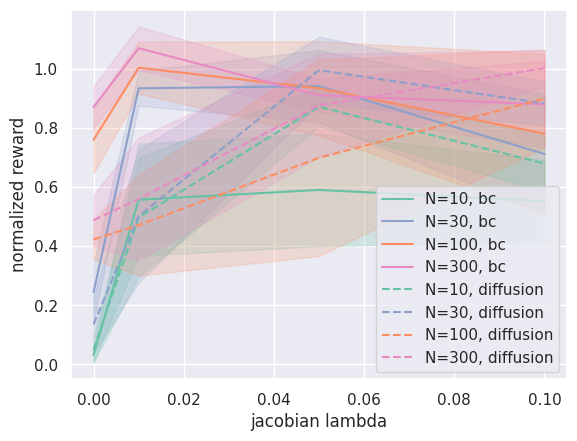

In [ ]:
def style(series, y):
    t, m, N = series
    return {
        "label": f"N={N}, {m}",
        "color_key": N,
        "linestyle": "--" if m == "diffusion" else "-",
    }
# filtered_data = data[data["lambda"] < 0.1]
filtered_data = data
filtered_data = filtered_data[filtered_data["num_traj"].isin([10, 30, 100, 300])]
filtered_data = filtered_data[data["lambda_param"] == "jac"]
filtered_data = filtered_data[filtered_data["lambda_val"] < 0.3]
plot(filtered_data, "lambda_val", ["test_reward"], style_func=style)
plt.xlabel("jacobian lambda")
plt.ylabel("normalized reward")

/tmp/ipykernel_3904891/1414848522.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = filtered_data[data["lambda_param"] == "zorder"]


Text(0, 0.5, 'normalized reward')

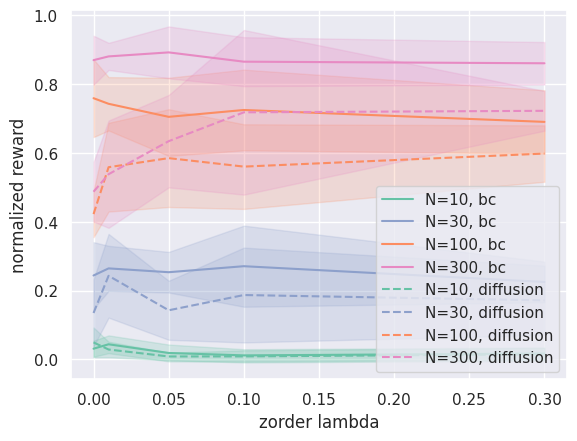

In [ ]:
filtered_data = data
filtered_data = filtered_data[filtered_data["num_traj"].isin([10, 30, 100, 300])]
filtered_data = filtered_data[data["lambda_param"] == "zorder"]
filtered_data = filtered_data[filtered_data["lambda_val"] <= 0.3]
plot(filtered_data, "lambda_val", ["test_reward"], style_func=style)
plt.xlabel("zorder lambda")
plt.ylabel("normalized reward")